# 0. TODO list
1. add MMD
2. change test dataset
3. two classfy for detail analysis, loss design, train architecture
4. 查看各个类别的置信度分布 T-SNE
5. content loss and other loss
6. CuB200 / Re-id / CIFAR-10

# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
from backgrad_utils import *
import os
import shutil
from cifar10_utils import show_images, parse_log, show_log, update
import utils
from mxnet.gluon.data.dataset import ArrayDataset
import utils
import os, shutil
import random
%matplotlib inline

ctx = mx.gpu(0)
arrayds_dir = '/home/hui/dataset/CIFAR10/arraydataset/'

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [2]:
from backgrad_utils import _transform_test, transform_train_DA1, load_all_data_label, data_loader2

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [3]:
EPS = 1e-30

mean=nd.array([0.4914, 0.4822, 0.4465])
std=nd.array([0.2023, 0.1994, 0.2010])
threshold = (nd.array([[0, 0, 0], [1, 1, 1]]) - mean) / std

use_loss = {"classify_loss": True, "content_loss": True}
loss_type = []
for key in use_loss:
    if use_loss[key]: loss_type.append(key)
feature_layers_index = [11]
content_weights = [1.0]
def extract_features(net, x, feature_layers_index=[]):
    features = []
    for i, block in enumerate(net):
        x = block(x)
        if i in feature_layers_index:
            features.append(x)
    return features, x
def content_loss(content_y_hat, content_y, weights):
    loss = []
    for y, y_hat, w in zip(content_y, content_y_hat, weights):
        loss.append(w * nd.mean(nd.abs(y - y_hat), axis=0, exclude=True))
    return nd.add_n(*loss)


class BackGradDataGenerator2(BackGradDataGenerator):
    """
        just a set of many static function
    """
    # 2. function to generate back_grad data
    
    @staticmethod
    def SGD(data, lr):
        # print nd.mean(data.grad).asscalar()
        data[:, :, :, :] = data - data.grad * lr
    
    @staticmethod
    def generate_backgrad_data_losses(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=False, 
                               loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), bn_control=None, sgd=None, threshold=None):
        """
            data is better in cpu, if data in ctx(global var), the returned backgrad_data is shallow copy of data.
        """
        context = data.context
        if bn_control is not None:
            bn_control.store()
        if sgd is None:
            sgd = BackGradDataGenerator.SGD

        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        features_y, output = extract_features(net.net, data, feature_layers_index)
        data.attach_grad()
        for iters in range(1, max_iters+1):
            losses = []
            with autograd.record():
                features_y_hat, output = extract_features(net.net, data, feature_layers_index)
                if use_loss["classify_loss"]: losses.append(-loss_f(output, label))
                if use_loss["content_loss"]: losses.append(content_loss(features_y_hat, features_y, content_weights))
                loss = nd.add_n(*losses)
            loss.backward()
            mean_loss = nd.mean(loss).asscalar()

            if iter_log and iters % 50 == 0:
                show_data(data[:5], clip)
                #print data[0, 0, :2, :10]
                #print data.grad[0, 0, :2, :10]
            if iter_log and iters % 5 == 0:
                print 'iter:', iters, 'loss:', mean_loss,
                for i in range(len(losses)):
                    print loss_type[i] + ":", nd.mean(losses[i]).asscalar(),
                print

            sgd(data, lr)
        if threshold is not None:
            for i in range(3):
                data[:, i, :, :] = data[:, i, :, :].clip(threshold[0, i].asscalar(), threshold[1, i].asscalar())
        if bn_control is not None:
            bn_control.load()
            
        return data.as_in_context(context), (loss.as_in_context(context), mean_loss, )
        
BGG = BackGradDataGenerator2

In [7]:
try:
    _origin_data_array
except BaseException:
    print "load data"
    _origin_data_array, _origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
def get_test_data(num, shuffle):
    indices = range(0, 50000)
    if shuffle: 
        random.shuffle(indices)
    indices = nd.array(indices[:num])
    origin_data_array, origin_label_array = _origin_data_array.take(indices), _origin_label_array.take(indices)
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=_transform_test)#_transform_test)
    origin_data = gluon.data.DataLoader(origin_ds, 128, shuffle=False, num_workers=0)
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=2)
    return origin_data, train_data

iter: 5 loss: 0.0127631 classify_loss: -0.000691855 content_loss: 0.013455
iter: 10 loss: -0.61391 classify_loss: -0.634832 content_loss: 0.0209216
iter: 15 loss: -0.914418 classify_loss: -0.940124 content_loss: 0.0257054
iter: 20 loss: -1.28264 classify_loss: -1.31375 content_loss: 0.0311081
iter: 25 loss: -1.43388 classify_loss: -1.46669 content_loss: 0.0328113
iter: 30 loss: -1.54534 classify_loss: -1.57974 content_loss: 0.0344006
iter: 35 loss: -1.61337 classify_loss: -1.64863 content_loss: 0.0352599
iter: 40 loss: -1.70756 classify_loss: -1.74421 content_loss: 0.0366557
iter: 45 loss: -1.73633 classify_loss: -1.77333 content_loss: 0.0369981


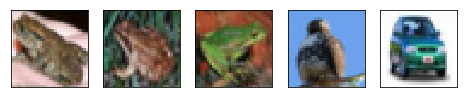

iter: 50 loss: -1.79798 classify_loss: -1.83576 content_loss: 0.0377815
iter: 55 loss: -1.83087 classify_loss: -1.86921 content_loss: 0.0383395
iter: 60 loss: -1.86899 classify_loss: -1.90774 content_loss: 0.038757
iter: 65 loss: -1.91018 classify_loss: -1.94939 content_loss: 0.039206
iter: 70 loss: -1.93537 classify_loss: -1.97501 content_loss: 0.0396435
iter: 75 loss: -1.93643 classify_loss: -1.97615 content_loss: 0.039721
iter: 80 loss: -1.95234 classify_loss: -1.99198 content_loss: 0.0396376
iter: 85 loss: -1.99962 classify_loss: -2.03993 content_loss: 0.0403131
iter: 90 loss: -2.00953 classify_loss: -2.04984 content_loss: 0.0403144
iter: 95 loss: -2.02874 classify_loss: -2.06935 content_loss: 0.0406108


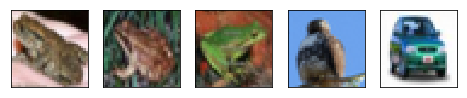

iter: 100 loss: -2.05106 classify_loss: -2.09206 content_loss: 0.0409997
iter: 5 loss: -0.00191811 classify_loss: -0.00191811
iter: 10 loss: -0.570801 classify_loss: -0.570801
iter: 15 loss: -1.32868 classify_loss: -1.32868
iter: 20 loss: -2.27604 classify_loss: -2.27604
iter: 25 loss: -2.96576 classify_loss: -2.96576
iter: 30 loss: -3.329 classify_loss: -3.329
iter: 35 loss: -3.8852 classify_loss: -3.8852
iter: 40 loss: -4.46422 classify_loss: -4.46422
iter: 45 loss: -4.71314 classify_loss: -4.71314


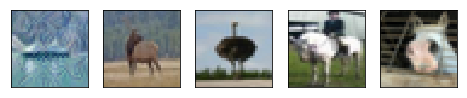

iter: 50 loss: -4.95386 classify_loss: -4.95386
iter: 55 loss: -5.17222 classify_loss: -5.17222
iter: 60 loss: -5.31526 classify_loss: -5.31526
iter: 65 loss: -5.49301 classify_loss: -5.49301
iter: 70 loss: -5.81315 classify_loss: -5.81315
iter: 75 loss: -6.32045 classify_loss: -6.32045
iter: 80 loss: -7.00422 classify_loss: -7.00422
iter: 85 loss: -7.26073 classify_loss: -7.26073
iter: 90 loss: -7.4989 classify_loss: -7.4989
iter: 95 loss: -7.67983 classify_loss: -7.67983


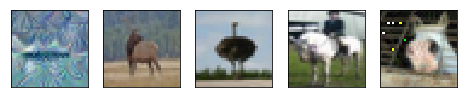

iter: 100 loss: -8.27249 classify_loss: -8.27249


In [8]:
def test():
    origin_data, train_data = get_test_data(256, True)
    net = ResNet(10)
    #net.initialize(ctx=ctx)
    #net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
    net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    bn_control = BNControl(net.net, False)
    for data,label in origin_data:
        backgrad_data, _ = BGG.generate_backgrad_data_losses(net,
                    data, label, max_iters=100, lr=0.1, bn_control=bn_control, threshold=threshold, iter_log=True)
        break
        
use_loss = {"classify_loss": True, "content_loss": True}
loss_type = []
for key in use_loss:
    if use_loss[key]: loss_type.append(key)
test()

use_loss = {"classify_loss": True, "content_loss": False}
loss_type = []
for key in use_loss:
    if use_loss[key]: loss_type.append(key)
test()

## compare content loss inference to diff, diff

In [53]:


def cal_evaluate(backgrad_data, data):
    tmp = (backgrad_data - data) ** 2
    diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
    MSE = nd.mean(tmp, axis=0, exclude=True).asnumpy()
    print np.mean(MSE), np.max(MSE), np.min(MSE), np.std(MSE)
    
def test():
    def nest_test(bn_control, threshold, log=False):
        backgrad_data, _ = BGG.generate_backgrad_data_losses(net,
                data, label, max_iters=10, lr=0.1, bn_control=bn_control, threshold=threshold)
        cal_evaluate(backgrad_data, data)
        show_data(backgrad_data[:5], clip=False)
    
        
    origin_data, train_data = get_test_data(256, True)
    
    net = ResNet(10)
    #net.initialize(ctx=ctx)
    #net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
    net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    print "accuracy:", utils.evaluate_accuracy(train_data, net, ctx)
    
    for data, label in origin_data:
        break
    show_data(data[:5], clip=False)
    bn_control = BNControl(net.net, True)
    nest_test(bn_control, threshold=threshold)

accuracy: 1.0


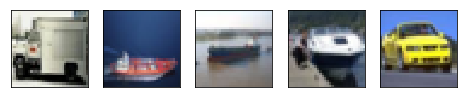

2.355e-07 2.35274e-05 1.92801e-10 2.1306e-06


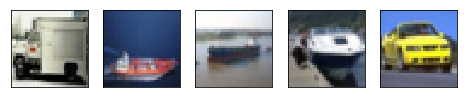

accuracy: 1.0


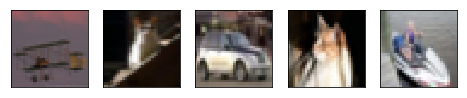

1.04248e-06 3.30423e-05 1.55073e-09 4.44111e-06


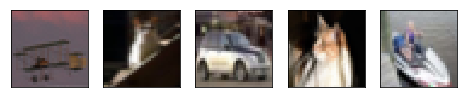

In [54]:
loss_type = {"classify_loss": True, "content_loss": True}
test()

loss_type = {"classify_loss": True, "content_loss": False}
test()

In [4]:
class BackGradTrain2(BackGradTrain):
    """
        1. add loss and diff/MSE/SNR to evaluate and control generate images
        2. BN layer: set use_gloabl_stats=True to use global mean/std and stop moving mean cal when genarate images, and set False after geneate.
        3. using DA after genereate images, means no DA when generate images
        4.
    """
    def run2(self, prob=0.5):
        self.initialize()
        if self.back_grad_args is not None:
            num_epoch_per_round = self.back_grad_args['num_epoch_per_round']
            max_iters, lr = self.back_grad_args['max_iters'], self.back_grad_args['lr']
            origin_data, b_verbose = self.back_grad_args['origin_data'], self.back_grad_args['verbose']
            use_batch_mean_std, train_ds = self.back_grad_args['use_batch_mean_std'], self.back_grad_args['train_ds']
            sgd, threshold = self.back_grad_args['sgd'], self.back_grad_args['threshold']
        epoch_round = 0
        
        bn_backup = BNControl(self.net.net, use_batch_mean_std) # to avoid update moving_mean/std when generate image
        
        for epoch in range(self.start_epoch, self.start_epoch+self.num_epochs):
            # 1. train net
            train_loss, train_acc, i, bloss = 0., 0., 0, 0
            for data, label in self.train_data:
                if i > 0 and random.random() < prob:
                    # origin_d = data
                    data,( _, _bloss) = BGG.generate_backgrad_data_losses(self.net, data.copy(), label, max_iters,
                                                lr, False, False, loss_f, bn_backup, sgd, threshold)
                    bloss += _bloss
                data, label = data.as_in_context(ctx), label.as_in_context(ctx)
                with autograd.record():
                    output = self.net(data)
                    loss = self.loss_f(output, label)
                loss.backward()
                for trainer in self.trainers:
                    trainer.step(data.shape[0])

                _loss = nd.mean(loss).asscalar() 
                _acc = utils.accuracy(output, label)
                train_loss += _loss
                train_acc += _acc

                self.after_iter(i, _loss, _acc)
                i += 1
                
            if b_verbose:
                print "bloss %.4f, " % (bloss / len(self.train_data)),
            epoch_round += 1
                
            self.after_epoch(epoch, train_loss, train_acc)
            
        if self.output_file == sys.stdout:
            sys.stdout = self.stdout
            self.output_file.close()

# 5. get net and do EXP

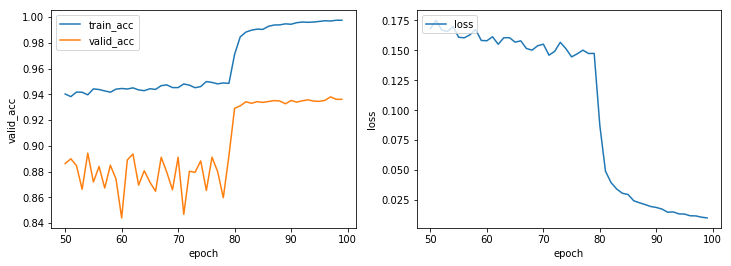

In [9]:
update('../../log/resnet18_me_200e.log', x_range=(50, 100))
# show_log('../../log/resnet18_me_200e.log')

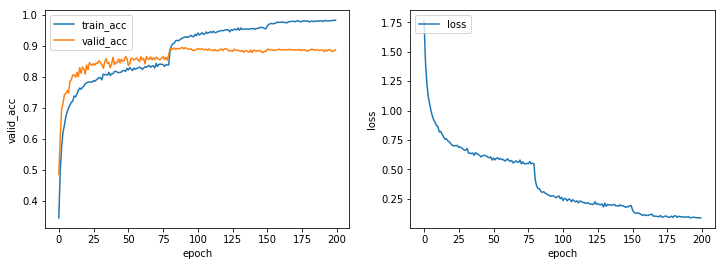

lr [0.1, 0.01, 0.001]


In [11]:
update('../../log/resnet18_me_backgrad_prob_online_iter10_lr05.log', x_range=(0, -1))
# show_log('../../log/resnet18_me_backgrad_prob_online_iter10_lr05.log')

##  5.2 simple test ,use_batch_mean_std=True/False

## 5.3 run in prob mode.

In [ ]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 100
policy = {'lr': 0.1, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [40, 75]}
w_key = []
trainers = None
log_file = "../../log/train11_resnet18_r1_i10_lr01_bT_prob.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 2, 2])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': True, 'train_ds': train_ds,
                  'sgd': None, 'threshold': threshold}

BackGradTrain2(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run2(0.5)
net.save_params("../../models/train11_resnet18_r1_i10_lr01_bT_prob")

In [ ]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 100
policy = {'lr': 0.1, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [40, 75]}
w_key = []
trainers = None
log_file = "../../log/train11_resnet18_r1_i10_lr01_bF_prob.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

# (origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
#     batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 2, 2])

back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': False, 'train_ds': train_ds,
                 'sgd': None, 'threshold': threshold}

BackGradTrain2(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run2(0.5)
net.save_params("../../models/train11_resnet18_r1_i10_lr01_bF_prob")

## 5.4 run in prob mode add MSE constraint

In [8]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 100
policy = {'lr': 0.1, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [40, 75]}
w_key = []
trainers = None
log_file = "../../log/train10_resnet18_r1_i10_lr01_bF_prob_MSE.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 2, 2])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': True, 'train_ds': train_ds,
                 'post_deal': BGG.MSE_constraint(0.003), 'sgd': None, 'threshold': threshold}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run2(0.5)
net.save_params("../../models/train10_resnet18_r1_i10_lr01_bF_prob_MSE")

## 5.4 try finetune baseline net in run2

In [6]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.load_params('../../models/resnet18_me_200e', ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 15
policy = {'lr': 0.01, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [10]}
w_key = []
trainers = None
log_file = "../../log/train10_resnet18_me_200e_bT_finetune_prob.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 1, 1])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': True, 'train_ds': train_ds,
                 'post_deal': None, 'sgd': None, 'threshold': threshold}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run2(0.5)

net.save_params("../../models/train10_resnet18_me_200e_bT_finetune_prob")

In [9]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.load_params('../../models/resnet18_me_200e', ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 100
policy = {'lr': 0.1, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [40, 75]}
w_key = []
trainers = None
log_file = "../../log/train10_resnet18_me_200e_bT_finetune2_prob.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

#(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
#    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 1, 1])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': True, 'train_ds': train_ds,
                 'post_deal': None, 'sgd': None, 'threshold': threshold}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run2(0.5)

net.save_params("../../models/train10_resnet18_me_200e_bT_finetune2_prob")

In [7]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.load_params('../../models/resnet18_me_200e', ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 15
policy = {'lr': 0.001, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': []}
w_key = []
trainers = None
log_file = "../../log/train10_resnet18_me_200e_bT_finetune3_prob.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

#(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
#    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 1, 1])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': True, 'train_ds': train_ds,
                 'post_deal': None, 'sgd': None, 'threshold': threshold}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run2(0.5)

net.save_params("../../models/train10_resnet18_me_200e_bT_finetune3_prob")

In [ ]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.load_params('../../models/resnet18_me_200e', ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 15
policy = {'lr': 0.01, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [10]}
w_key = []
trainers = None
log_file = "../../log/train10_resnet18_me_200e_bF_finetune_prob.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

# (origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
#     batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 1, 1])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': False, 'train_ds': train_ds,
                 'post_deal': None, 'sgd': None, 'threshold': threshold}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run2(0.5)

net.save_params("../../models/train10_resnet18_me_200e_bF_finetune_prob")

## 5.5 try finetune baseline net in run mode

In [ ]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.load_params('../../models/resnet18_me_200e', ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 15
policy = {'lr': 0.01, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [10]}
w_key = []
trainers = None
log_file = "../../log/train10_resnet18_me_200e_bT_finetune.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 1, 1])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': True, 'train_ds': train_ds,
                 'post_deal': None, 'sgd': None, 'threshold': threshold}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run()

net.save_params("../../models/train10_resnet18_me_200e_bT_finetune_run1")

In [ ]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.load_params('../../models/resnet18_me_200e', ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 15
policy = {'lr': 0.01, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [10]}
w_key = []
trainers = None
log_file = "../../log/train10_resnet18_me_200e_bF_finetune.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 1, 1])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': False, 'train_ds': train_ds,
                 'post_deal': None, 'sgd': None, 'threshold': threshold}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run()

net.save_params("../../models/train10_resnet18_me_200e_bF_finetune_run1")